<a href="https://colab.research.google.com/github/vviia/ml-identification-of-hypertension/blob/main/HRV_analizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neurokit2

     |████████████████████████████████| 1.1 MB 14.9 MB/s 


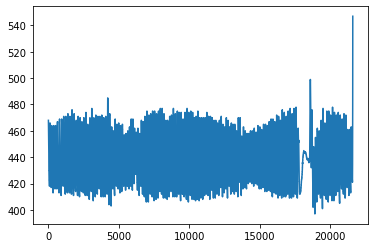

In [ ]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib.patches import Ellipse

ppg_simulated=pd.read_csv('/content/drive/MyDrive/CNN-TESIS/RAW-DATA-TEKANAN-DARAH/RAW/p114.csv')
plt.plot(ppg_simulated)
plt.show()

time domain analyze

In [ ]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

In [ ]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

In [ ]:
def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    
    return sd1, sd2

In [ ]:
P114=pd.read_csv('/content/drive/MyDrive/CNN-TESIS/RAW-DATA-TEKANAN-DARAH/RAW/p114.csv',  header=None)
ppg_and_ecg=np.array(P114)

In [ ]:
ppg = P114[0]

In [ ]:
ppg.ndim

1

In [ ]:
ppg.head()

0    467.97
1    467.97
2    466.97
3    466.97
4    457.98
Name: 0, dtype: float64

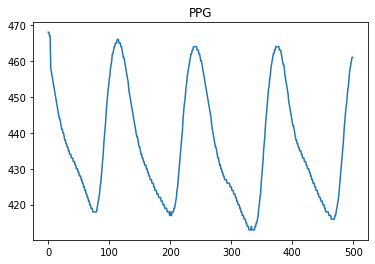

In [ ]:
plt.plot(ppg_and_ecg[0:500])
plt.title("PPG", color = "black")
plt.tick_params(axis="both", colors = "black")

--------------------------------------------------- alternatif-----------------------------------

In [ ]:
len(ppg)

21600

posisi titik puncak : [  114.   240.   375.   506.   642.   790.   943.  1085.  1233.  1384.
  1527.  1675.  1824.  1967.  2107.  2247.  2379.  2514.  2660.  2798.
  2942.  3079.  3222.  3366.  3511.  3648.  3787.  3926.  4067.  4208.
  4349.  4487.  4736.  4857.  4985.  5114.  5250.  5756.  5874.  5995.
  6112.  6353.  6595.  6719.  6850.  6991.  7131.  7260.  7396.  7536.
  7674.  7813.  7941.  8069.  8200.  8330.  8465.  8604.  8734.  8869.
  9007.  9147.  9281.  9421.  9552.  9693.  9835.  9972. 10103. 10233.
 10358. 10482. 10607. 10736. 10861. 10990. 11115. 11244. 11366. 11496.
 11619. 11747. 11875. 12003. 12134. 12262. 12388. 12506. 12626. 12744.
 12856. 12981. 13101. 13230. 13478. 13603. 13842. 14606. 14867. 15004.
 15132. 15267. 15403. 15534. 15663. 15797. 15933. 16065. 16197. 16332.
 16460. 16596. 16736. 16874. 17013. 17154. 17292. 17429. 17572. 17720.
 18588. 18694. 19084. 19353. 19486. 19618. 19756. 19895. 20025. 20162.
 20299. 20428. 20568. 20707. 20841. 20974. 21107. 21233

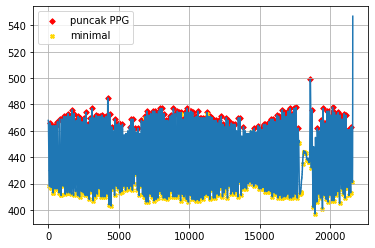

In [ ]:
# x and y definition
x= np.linspace(0,21599,21600) 
y= ppg

#find peak
peaks = find_peaks(y, height=460, threshold=0, distance=10)
height = peaks[1]['peak_heights']
peak_post= x[peaks[0]]

  
print("posisi titik puncak :", peak_post)


#menemukan nilai minimum
y2=y*-1
minima=find_peaks(y2)
min_pos=x[minima[0]]
min_height=y2[minima[0]]

#print titik puncak
peak_coordinate=peak_post
    #print(peak_coordinate)
#banyaknya puncak
    # print(len(peak_coordinate)) 
    #output 40
#data titik ke2 sampai 40
data1=peak_coordinate[1:]
#data titik ke1-39
data2=peak_coordinate[:-1]
#jarak antar puncak (pengurangan array)
distance= data1-data2
#mencari rata-rata jarak
total = np.sum(distance)
totaldistance = total
average= totaldistance/len(distance)
#pengolahan data delay 10
# RR = 10*average
# HR= 60000/RR

#pengolahan data delay 05
RR=average*5
HR=60000/RR

#print(min(peak_post))
print("----------------------------------------------------------------------")
print("jarak antar puncak :", distance)   #selisih
print("----------------------------------------------------------------------")
print("jarak terdekat :", min(distance))
print("----------------------------------------------------------------------")
print("jarak terjauh :", max(distance))
print("----------------------------------------------------------------------")
print("rata-rata jarak :", average)
print("----------------------------------------------------------------------")
print("banyaknya peak :", len(distance))
print("----------------------------------------------------------------------")
print("jumlah jarak:", total)
print("----------------------------------------------------------------------")
print("HR", HR)

#plotting
fig = plt.figure()
ax= fig.subplots()
ax.plot(x,y)
ax.scatter(peak_post, height, color='r', s=15, marker='D', label='puncak PPG')
ax.scatter(min_pos, min_height*-1, color='gold', s=15, marker='X', label='minimal')
ax.legend()
ax.grid()
plt.show()

In [ ]:
diff_sig_2=np.diff(ppg_and_ecg[1])

In [ ]:
diff_sig_2.ndim

1

In [ ]:
# HR will probably not go below 30 bpm : distance=500*(30/60))
# prominence found experimentally
peaks_2, _ = find_peaks(diff_sig_2, distance=50*(30/60), prominence=0.001)
peaks_2

array([], dtype=int64)

IndexError: ignored

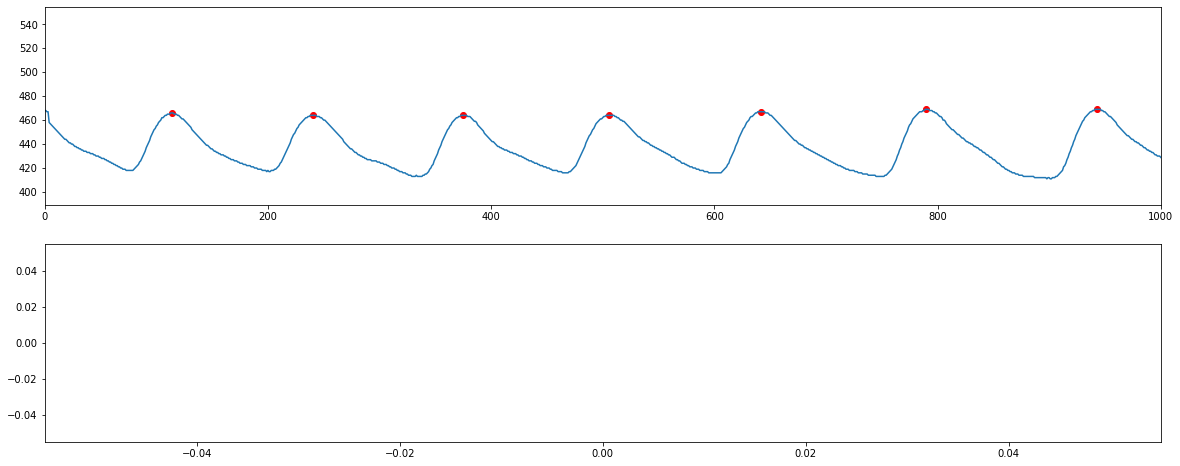

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.plot(ppg_and_ecg)
plt.scatter(peak_post, ppg [peak_post], color="red")
plt.gca().set_xlim(0, 1000)
plt.subplot(2,1,2)
plt.plot(diff_sig_2)
plt.scatter(peak_post, diff_sig_2[peak_post], color="red")
plt.gca().set_xlim(0, 1000)
plt.show()

In [ ]:
rr_2 = np.diff(peak_post)
corr_rr_2 = rr_2*10

In [ ]:
corr_rr_2

array([1260., 1350., 1310., 1360., 1480., 1530., 1420., 1480., 1510.,
       1430., 1480., 1490., 1430., 1400., 1400., 1320., 1350., 1460.,
       1380., 1440., 1370., 1430., 1440., 1450., 1370., 1390., 1390.,
       1410., 1410., 1410., 1380., 2490., 1210., 1280., 1290., 1360.,
       5060., 1180., 1210., 1170., 2410., 2420., 1240., 1310., 1410.,
       1400., 1290., 1360., 1400., 1380., 1390., 1280., 1280., 1310.,
       1300., 1350., 1390., 1300., 1350., 1380., 1400., 1340., 1400.,
       1310., 1410., 1420., 1370., 1310., 1300., 1250., 1240., 1250.,
       1290., 1250., 1290., 1250., 1290., 1220., 1300., 1230., 1280.,
       1280., 1280., 1310., 1280., 1260., 1180., 1200., 1180., 1120.,
       1250., 1200., 1290., 2480., 1250., 2390., 7640., 2610., 1370.,
       1280., 1350., 1360., 1310., 1290., 1340., 1360., 1320., 1320.,
       1350., 1280., 1360., 1400., 1380., 1390., 1410., 1380., 1370.,
       1430., 1480., 8680., 1060., 3900., 2690., 1330., 1320., 1380.,
       1390., 1300.,

In [ ]:
timedomain(corr_rr_2)

{'Max HR (beats/min)': 56.60377358490566,
 "Mean HR (Kubios' style) (beats/min)": 39.02302077484559,
 'Mean HR (beats/min)': 43.043168562299435,
 'Mean RR (ms)': 1537.5539568345323,
 'Min HR (beats/min)': 6.912442396313364,
 'NNxx': 61,
 'RMSSD (ms)': 1247.6824893388937,
 'STD HR (beats/min)': 7.770029192847323,
 'STD RR/SDNN (ms)': 924.7109925541766,
 'pNNxx (%)': 43.884892086330936}

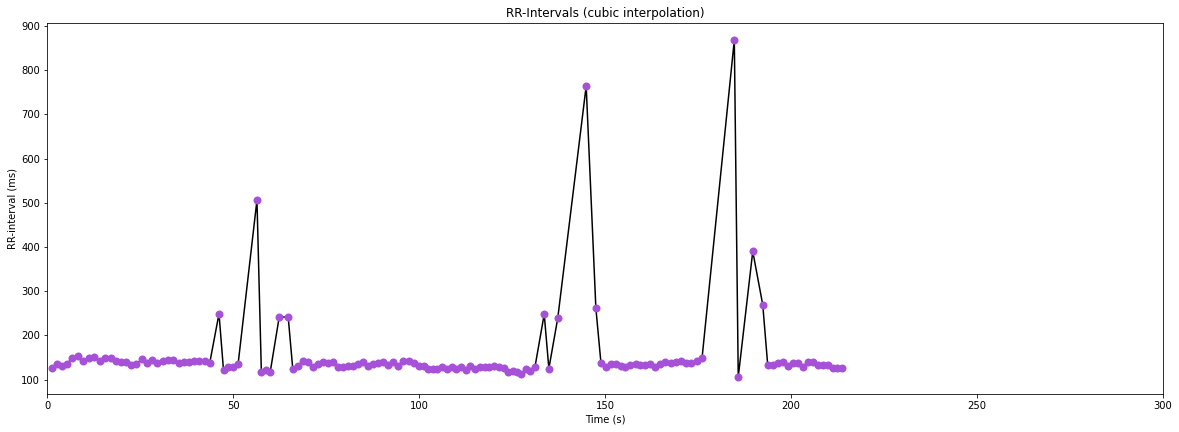

In [ ]:
x_2 = np.cumsum(rr_2)/ 100.0
f_2 = interp1d(x_2, rr_2, kind='cubic',fill_value="extrapolate")

# sample rate for interpolation
fs = 4.0
steps = 1 / fs

# now we can sample from interpolation function
xx_2 = np.arange(1, np.max(x_2), steps)

rr_interpolated = f_2(xx_2)

plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("RR intervals")
plt.plot(x_2, rr_2, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.title("Interpolated")
plt.gca().set_xlim(0, 300)

#plt.subplot(212)
plt.title("RR-Intervals (cubic interpolation)")
#plt.plot(xx_2, rr_interpolated_2, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
plt.gca().set_xlim(0, 300)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.show()

In [ ]:
print("Frequency domain metrics:")
results_2, fxx_2, pxx_2 = frequency_domain(rr_interpolated)

for k, v in results_2.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 12751.53
- Power LF (ms2): 8627.03
- Power HF (ms2): 435.86
- Power Total (ms2): 21814.42
- LF/HF: 19.79
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.05
- Peak HF (Hz): 0.16
- Fraction LF (nu): 95.19
- Fraction HF (nu): 4.81


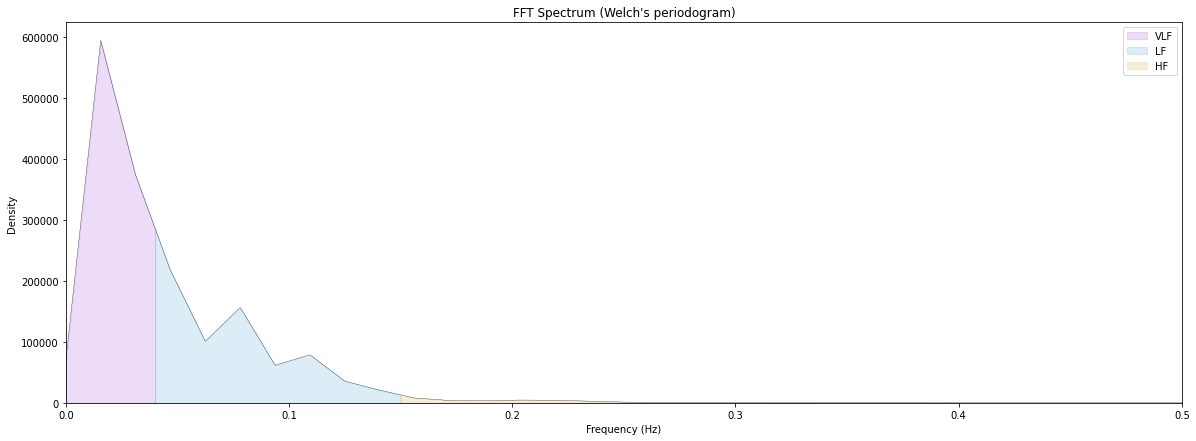

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(fxx_2, pxx_2, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx_2, pxx_2)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

SD1: 88.224 ms
SD2: 97.113 ms


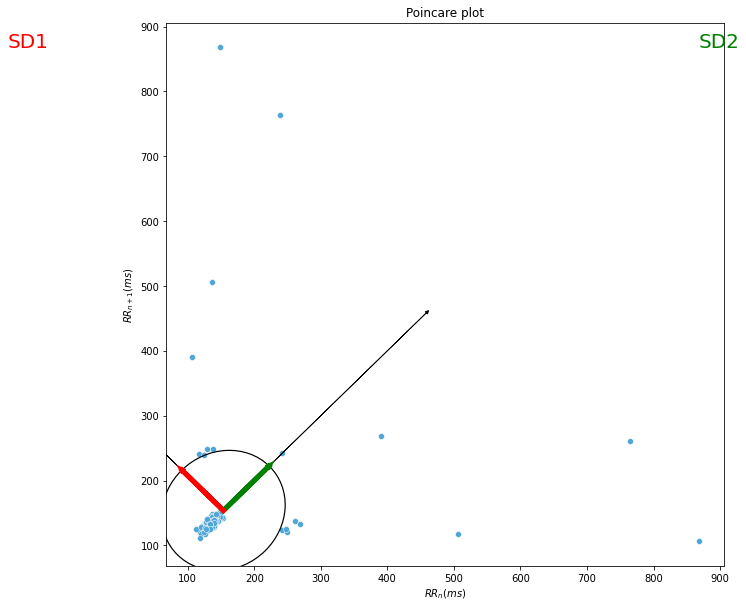

In [ ]:
import seaborn as sns
from matplotlib.patches import Ellipse
sd1_2, sd2_2 = plot_poincare(rr_2)
print("SD1: %.3f ms" % sd1_2)
print("SD2: %.3f ms" % sd2_2)

In [ ]:
ecg_signals, info  = nk.ecg_process(ppg, sampling_rate=100)

/usr/local/lib/python3.7/dist-packages/neurokit2/signal/signal_phase.py:82: RuntimeWarning: invalid value encountered in remainder
  prophase = np.mod(np.angle(scipy.signal.hilbert(signal)), pi2)


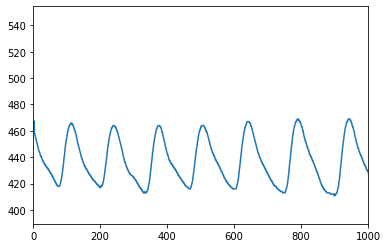

In [ ]:
plt.plot(ppg)
plt.scatter(info['ECG_R_Peaks'], ppg[info['ECG_R_Peaks']], color="red")
plt.gca().set_xlim(0, 1000)
plt.show()

In [ ]:
rr_ecg = np.diff(info['ECG_R_Peaks'])
corr_rr_ecg = rr_ecg*10

In [ ]:
!pip install hrv-analysis

In [ ]:
!pip install pyhrv

     |████████████████████████████████| 3.2 MB 9.0 MB/s 
     |████████████████████████████████| 228 kB 44.3 MB/s 
     |████████████████████████████████| 1.5 MB 65.3 MB/s 
  Created wheel for biosppy: filename=biosppy-0.8.0-py2.py3-none-any.whl size=100176 sha256=6c2c0a1c8647879546f792f09c762c39494a90c203c29487e199c0109c374633
  Stored in directory: /root/.cache/pip/wheels/32/17/9d/77adbf0db713546eaa1c7a1480b2dce91fa724a133115dc20c
  Created wheel for spectrum: filename=spectrum-0.8.0-cp37-cp37m-linux_x86_64.whl size=234823 sha256=8e1700b6e6ca0cde7bbe6489337591a5f23434194698231e52b9aefaf230b9af
  Stored in directory: /root/.cache/pip/wheels/ac/a0/2b/aba9ac3cce046bc454a44d0db5b711b4e927a0dd33a93e9d98
Successfully built biosppy spectrum


In [ ]:
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values

In [ ]:
rr_intervals_list = info['ECG_R_Peaks']

In [ ]:
import pyhrv.tools as tools

In [ ]:
peaks_2, _ = find_peaks(diff_sig_2, distance=100*(30/60), prominence=0.01)

In [ ]:
#nni = tools.nn_intervals(rpeaks)

In [ ]:
import pyhrv.frequency_domain as fd
nni = tools.nn_intervals(rr_intervals_list)
result = fd.welch_psd(nni=nni)
# Access peak frequencies using the key 'fft_peak'
print(result['fft_peak'])

ValueError: ignored

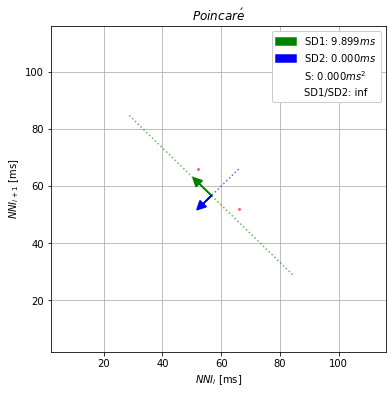

9.899494936611665


In [ ]:
import pyhrv.nonlinear as nl
result = nl.poincare(nni)
print(result['sd1'])

In [ ]:
result = nl.sample_entropy(nni)
print(result['sampen'])

inf


- Makowski, D., Pham, T., Lau, Z. J., Brammer, J. C., Lesspinasse, F., Pham, H., Schölzel, C., & S H Chen, A. (2020). NeuroKit2: A Python Toolbox for Neurophysiological Signal Processing. Retrieved May 07, 2020, from https://github.com/neuropsychology/NeuroKit
- https://www.kaggle.com/stetelepta/exploring-heart-rate-variability-using-python